In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import PIL
import csv
import torch
import torchvision

/opt/anaconda3/envs/pytorch3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/anaconda3/envs/pytorch3/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <DDABACEB-F2EA-368C-80DD-40745DFB96F8> /opt/anaconda3/envs/pytorch3/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <DFED4914-D311-3EA0-A4AC-112C5F89503D> /opt/anaconda3/envs/pytorch3/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


In [2]:
class MyDataset(torch.utils.data.Dataset):

    def __init__(self, label_path, transform=None):
        x = []
        y = []
        file = open(label_path, 'r')
        data = csv.reader(file)
        for row in data:
            x.append(row[0])
            y.append(float(row[1]))
        file.close()
    
        self.x = x    
        self.y = torch.from_numpy(np.array(y)).float().view(-1, 1)
     
        self.transform = transform
  
  
    def __len__(self):
        return len(self.x)
  
  
    def __getitem__(self, i):
        img = PIL.Image.open(self.x[i]).convert('RGB')
        if self.transform is not None:
              img = self.transform(img)
    
        return img, self.y[i]

In [3]:
transform = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Resize((26,26)),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

data_dir = './csv/age2.csv'

dataset = MyDataset(data_dir, transform=transform)

# train_data_dir = './csv/effspin5_train.csv'



# trainset = MyDataset(train_data_dir, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True)


In [4]:
import numpy as np
import torch
import torchvision.datasets as datasets

# 元のデータセット
# dataset_dir = "/data/hymenoptera_data/train"
# dataset = datasets.ImageFolder(dataset_dir)

# 学習データ、検証データに 8:2 の割合で分割する。
# train_size = int(0.7 * len(dataset))
indices = np.arange(len(dataset))

train_dataset = torch.utils.data.Subset(dataset, indices[0:8000])
val_dataset = torch.utils.data.Subset(dataset, indices[8000:9500])
test_dataset = torch.utils.data.Subset(dataset, indices[9500:])

print(f"full: {len(dataset)} -> train: {len(train_dataset)}, val: {len(val_dataset)}, test: {len(test_dataset)}")

full: 9780 -> train: 8000, val: 1500, test: 280


In [5]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
validloader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

In [6]:
class RegressionNet(torch.nn.Module):

    def __init__(self):
        super(RegressionNet, self).__init__()

        self.conv1 = torch.nn.Conv2d(3, 16, 3)
        self.pool1 = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(16, 32, 3)
        self.pool2 = torch.nn.MaxPool2d(2, 2)

        self.fc1 = torch.nn.Linear(32 *5 * 5, 1024)
        self.fc2 = torch.nn.Linear(1024, 1024)
        self.fc3 = torch.nn.Linear(1024, 1)


    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = self.pool1(x)
        x = torch.nn.functional.relu(self.conv2(x))
        x = self.pool2(x)
        
        x = x.view(-1, 32 * 5 * 5)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.fc3(x)
        
        return x

net = RegressionNet()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = net.to(device)

In [7]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
# criterion = torch.nn.MSELoss()
# criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.L1Loss()

In [8]:
import time
num_epocs = 5

list1=[]
list2=[]

train_loss = []
valid_loss = []
time_sta = time.time()
for epoch in range(num_epocs):
  # 学習
    net.train()
    running_train_loss = 0.0
    running_acc = 0.0
    with torch.set_grad_enabled(True):
        for data in trainloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            a = outputs.tolist()
            b = labels.tolist()
            list1.append(a)
            list2.append(b)
            loss = criterion(outputs, labels)
            running_train_loss += loss.item()
            loss.backward()
            optimizer.step()

    train_loss.append(running_train_loss / len(trainloader))
  
  # 検証
    net.eval()
    running_valid_loss = 0.0
    val_running_acc = 0.0
    with torch.set_grad_enabled(False):
        for data in validloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            running_valid_loss += loss.item()

    valid_loss.append(running_valid_loss / len(validloader))

    print('#epoch:{}\ttrain loss: {}\tvalid loss: {}'.format(epoch,
                                                running_train_loss / len(trainloader), 
                                                running_valid_loss / len(validloader)))
    
time_end = time.time()
tim = time_end- time_sta
print(tim)

#epoch:0	train loss: 16.45925156211853	valid loss: 18.406739763895672
#epoch:1	train loss: 12.104994054794311	valid loss: 10.592007482290269
#epoch:2	train loss: 10.685088909029961	valid loss: 11.085132793744405
#epoch:3	train loss: 10.210381445884705	valid loss: 10.263324094136555
#epoch:4	train loss: 9.598721054792405	valid loss: 9.652085589408875
84.36107611656189


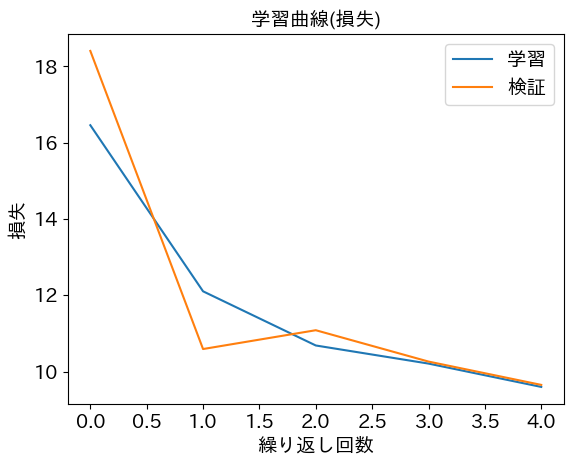

In [9]:
import japanize_matplotlib
plt.plot(train_loss, label='学習')
plt.plot(valid_loss, label='検証')
plt.xlabel('繰り返し回数',fontsize=14)
plt.ylabel('損失',fontsize=14)
plt.title('学習曲線(損失)',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [10]:
PATH = "./model.pt"
torch.save(net.state_dict(), PATH)

In [11]:
test_loss=[]
running_test_loss = 0.0
pred=[]
ans=[]
with torch.set_grad_enabled(False):
    for data in testloader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        list1 = labels.tolist()
        outputs = net(inputs)
        list2 = outputs.tolist()
        for i in range(len(list1)):
            ans.append(list1[i])
        for i in range(len(list2)):
            pred.append(list2[i])
        loss = criterion(outputs, labels)
        running_test_loss += loss.item()

test_loss.append(running_test_loss / len(testloader))

print('test loss: {}'.format(running_test_loss / len(testloader)))
                

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


test loss: 11.96269941329956


In [12]:
import collections

def flatten(l):
    for el in l:
        if isinstance(el, collections.abc.Iterable) and not isinstance(el, (str, bytes)):
            yield from flatten(el)
        else:
            yield el
            

In [13]:
ans= list(flatten(ans))
pred= list(flatten(pred))

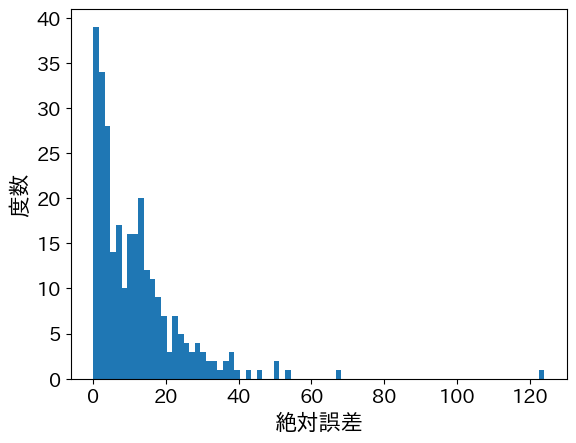

123.91786193847656
0.13172340393066406
11.962699403081622
9.001568794250488
12.826642638288595


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import warnings
warnings.simplefilter('ignore')
import japanize_matplotlib
import statistics
ans= list(flatten(ans))
pred= list(flatten(pred))

abser=[]
for i in range(len(ans)):
    abser.append(abs(pred[i]-ans[i]))
    
plt.hist(abser,bins=80)
plt.xlabel('絶対誤差',fontsize=16)
plt.ylabel('度数',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

print(max(abser))
print(min(abser))
print(statistics.mean(abser))
print(statistics.median(abser))
print(statistics.stdev(abser))

In [15]:
from PIL import Image

x = []
y = []
file = open('./csv/age2.csv', 'r')
data = csv.reader(file)
for row in data:
    x.append(row[0])
    y.append(float(row[1]))
file.close()

In [16]:
imagelist=[]
labellist=[]
for i in range(40):
    imagelist.append(Image.open(x[9500+i]))
    labellist.append(ans)
    # plt.imshow(Image.open(x[i]))

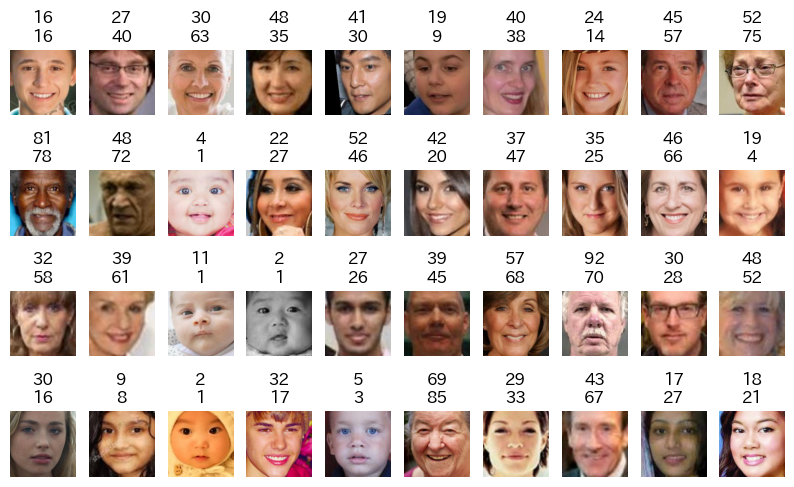

In [17]:
import numpy as np
from PIL import Image
import matplotlib.pyplot  as plt
import japanize_matplotlib
fig = plt.figure(figsize=(10,6))
for i, im in enumerate(imagelist):
    fig.add_subplot(4,10,i+1).set_title('{}\n{}'.format(int(pred[i]),int(ans[i])))
    plt.axis('off')
    plt.imshow(im)
plt.show()

31


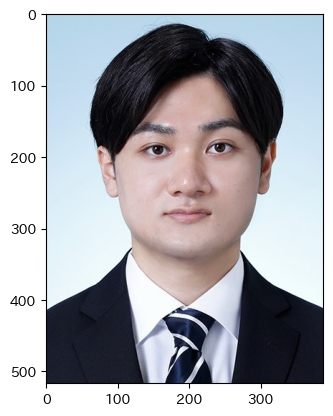

In [18]:
img = Image.open('./iwanagahibiki.jpeg')
img2 = transform(img)
outputs = net(img2)
pre = outputs.tolist()[0][0]
print(int(pre))
plt.imshow(img)

In [6]:
img = PIL.Image.open('./iwanagahibiki.jpeg')
img2 = transform(img)


In [8]:
print(img2.size())

torch.Size([3, 26, 26])
